<a href="https://colab.research.google.com/github/dmldatasci/nonprofit-seeding-deep-learning/blob/main/AlphabetSoup_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alphabet Soup Application Classifier

## Data Preprocessing

In [11]:
# load dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

In [12]:
application_df = pd.read_csv('https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv')
application_df.head(5)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [13]:
# drop the non-beneficial ID columns, 'EIN' and 'NAME'
application_df = application_df.drop(['EIN', 'NAME'], axis=1)
application_df.head(5)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [14]:
# determine the number of unique values in each column
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [15]:
# look at APPLICATION_TYPE value counts for binning
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: count, dtype: int64

In [16]:
# choose a cutoff value and create a list of application types to be replaced
app_counts = pd.DataFrame({'APPLICATION_TYPE' : application_df['APPLICATION_TYPE'].value_counts().index, 
                           'counts' : application_df['APPLICATION_TYPE'].value_counts().values}).set_index('APPLICATION_TYPE')
application_types_to_replace = app_counts.loc[app_counts['counts'] <= 15].index

# replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
T13         66
T12         27
T2          16
Other       11
Name: count, dtype: int64

In [17]:
# look at CLASSIFICATION value counts for binning
application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: count, Length: 71, dtype: int64

In [18]:
# look at CLASSIFICATION value counts >1
app_counts = application_df['CLASSIFICATION'].value_counts()
app_counts[app_counts > 1]

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: count, dtype: int64

In [19]:
# choose a cutoff value and create a list of classifications to be replaced
classifications_to_replace = app_counts[app_counts < 20].index

# replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
Other      207
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
Name: count, dtype: int64

In [20]:
# convert categorical data to numeric with `pd.get_dummies`
cat_var = [col for col in application_df if application_df[col].dtypes=='object']

dummy_df = pd.get_dummies(application_df[cat_var])
dummy_df.head(5)

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T12,APPLICATION_TYPE_T13,APPLICATION_TYPE_T19,APPLICATION_TYPE_T2,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [21]:
# incorporate dummy variables into the data frame and drop categorical variables
clean_df = pd.concat([application_df, dummy_df], axis=1)
clean_df = clean_df.drop(cat_var, axis=1)
clean_df.head(5)

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T12,APPLICATION_TYPE_T13,APPLICATION_TYPE_T19,APPLICATION_TYPE_T2,APPLICATION_TYPE_T3,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1,108590,1,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
2,1,5000,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1,6692,1,False,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False
4,1,142590,1,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False


In [22]:
# split our preprocessed data into our features and target arrays
X = clean_df.drop('IS_SUCCESSFUL', axis=1)
y = clean_df['IS_SUCCESSFUL']

# split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=80)
print(f"""
The dimensions of X_train are {X_train.shape}.
The dimensions of X_test are {X_test.shape}.
The dimensions of y_train are {y_train.shape}.
The dimensions of y_test are {y_test.shape}.
""")


The dimensions of X_train are (25724, 63).
The dimensions of X_test are (8575, 63).
The dimensions of y_train are (25724,).
The dimensions of y_test are (8575,).



In [23]:
# instantiate a StandardScaler
scaler = StandardScaler()

# fit the StandardScaler
X_scaler = scaler.fit(X_train)

# scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train & Evaluate the Model

In [30]:
nn_model = tf.keras.models.Sequential()

# define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_model.add(tf.keras.layers.Dense(units=120, activation="relu", input_dim=63))

# first hidden layer
nn_model.add(tf.keras.layers.Dense(units=60, activation="tanh"))

# second hidden layer
nn_model.add(tf.keras.layers.Dense(units=20, activation="relu"))

# output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 120)               7680      
                                                                 
 dense_8 (Dense)             (None, 60)                7260      
                                                                 
 dense_9 (Dense)             (None, 20)                1220      
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 16181 (63.21 KB)
Trainable params: 16181 (63.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
# train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 579us/step - loss: 0.5670 - accuracy: 0.7219
Epoch 2/100
804/804 [==============================] - 0s 584us/step - loss: 0.5517 - accuracy: 0.7288
Epoch 3/100
804/804 [==============================] - 0s 599us/step - loss: 0.5483 - accuracy: 0.7307
Epoch 4/100
804/804 [==============================] - 0s 565us/step - loss: 0.5473 - accuracy: 0.7318
Epoch 5/100
804/804 [==============================] - 0s 610us/step - loss: 0.5454 - accuracy: 0.7338
Epoch 6/100
804/804 [==============================] - 0s 568us/step - loss: 0.5446 - accuracy: 0.7317
Epoch 7/100
804/804 [==============================] - 0s 554us/step - loss: 0.5439 - accuracy: 0.7336
Epoch 8/100
804/804 [==============================] - 0s 583us/step - loss: 0.5422 - accuracy: 0.7336
Epoch 9/100
804/804 [==============================] - 0s 554us/step - loss: 0.5417 - accuracy: 0.7342
Epoch 10/100
804/804 [==============================] - 0s 550us/step - l

In [33]:
# evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=5)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.5645344853401184, Accuracy: 0.7300291657447815


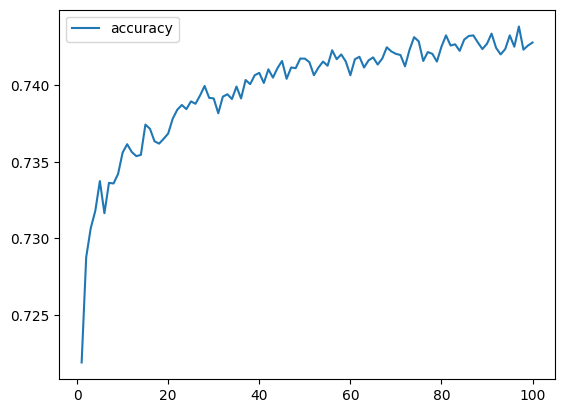

In [34]:
import matplotlib.pyplot as plt

# create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [35]:
# export the v1 model to HDF5 file
nn_model.save("output/AlphabetSoupCharity.h5")

/Users/davidlevy/Documents/Work/education/berkeley_ds/module_challenges/deep-learning-challenge/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
